In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00


In [3]:
import optuna
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
from sklearn.utils import class_weight
import time
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping


In [4]:
df_news_100=pd.read_parquet('/content/drive/My Drive/Colab Notebooks/fake_news/trials_marco/news_cleaned_truncated_100_each_processed.parquet.gzip')
#df_news=pd.read_parquet('/content/drive/My Drive/Colab Notebooks/fake_news/trials_marco/news_cleaned_truncated_30k_each.parquet.gzip')
#max_text_length = df_news['content'].apply(len).max()
#print("Maximum text length:", max_text_length)

In [4]:
df_news=pd.read_parquet('/content/drive/My Drive/Colab Notebooks/fake_news/trials_tobi/news_cleaned_truncated_68k_samples.parquet.gzip')
df_news.dropna(inplace=True)
print(df_news.head())
print(df_news.type.value_counts())
max_text_length = df_news['content'].apply(len).max()
print("Maximum text length:", max_text_length)


              type                                            content  \
3637243  clickbait  black lives matter blm gaining public attentio...   
1932734  clickbait  deeppocketed republicans threaten withhold sup...   
1899477  clickbait  deserted stone alleyway joyful chorus halleluj...   
1756062  clickbait  new study conservatives tested low iq childhoo...   
1850889  clickbait  asked speak republican convention legendary fo...   

                                         content_tokenized  
3637243  [101, 2304, 3268, 3043, 1038, 13728, 8550, 227...  
1932734  [101, 2784, 6873, 19869, 3064, 10643, 15686, 2...  
1899477  [101, 12768, 2962, 8975, 4576, 6569, 3993, 716...  
1756062  [101, 2047, 2817, 11992, 7718, 2659, 26264, 55...  
1850889  [101, 2356, 3713, 3951, 4680, 8987, 2374, 2873...  
reliable      18638
political     12698
bias           8649
fake           7993
conspiracy     6548
rumor          4568
unknown        2998
clickbait      2281
unreliable     1170
junksci        

In [49]:
# base model

%%time
# Parameters
vocab_size = 10000 # This can be adjusted
max_length = 60 # Adjust based on text length
embedding_dim = 3000
batch_size = 124
epochs = 2

# Preparing the Dataset
X = df_news['content']
y = df_news['type']

# Convert labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Tokenize text
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(12, activation='softmax'))


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')


Epoch 1/2
441/441 [==============================] - 37s 80ms/step - loss: 1.7835 - accuracy: 0.4009 - val_loss: 1.4944 - val_accuracy: 0.5072
Epoch 2/2
427/427 [==============================] - 2s 4ms/step - loss: 1.2203 - accuracy: 0.6192
Accuracy: 0.6191941499710083
CPU times: user 43.5 s, sys: 1.78 s, total: 45.3 s
Wall time: 56.2 s


In [50]:
# Optimize parameters with optuna
%%time

def create_model(trial):
    vocab_size = trial.suggest_categorical('vocab_size', [10000, 20000, 30000])
    embedding_dim = trial.suggest_categorical('embedding_dim', [500, 1000, 3000])
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def objective(trial):
    model = create_model(trial)

    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 5, 15)

    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=0)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, n_jobs=-1)  # You can adjust the number of trials

best_params = study.best_params
print("Best parameters: ", best_params)

[I 2024-01-02 15:50:07,351] A new study created in memory with name: no-name-f1d67afd-ded7-4835-9d5c-e9e4955d4f0c
[I 2024-01-02 15:53:46,411] Trial 3 finished with value: 0.6120879054069519 and parameters: {'vocab_size': 10000, 'embedding_dim': 1000, 'lstm_units': 64, 'dropout_rate': 0.3805247989927393, 'batch_size': 64, 'epochs': 5}. Best is trial 3 with value: 0.6120879054069519.
[I 2024-01-02 15:55:31,453] Trial 0 finished with value: 0.578315019607544 and parameters: {'vocab_size': 10000, 'embedding_dim': 1000, 'lstm_units': 32, 'dropout_rate': 0.23629893883456501, 'batch_size': 64, 'epochs': 8}. Best is trial 3 with value: 0.6120879054069519.
[I 2024-01-02 16:00:05,676] Trial 1 finished with value: 0.5833699703216553 and parameters: {'vocab_size': 20000, 'embedding_dim': 1000, 'lstm_units': 64, 'dropout_rate': 0.13813108914958902, 'batch_size': 64, 'epochs': 14}. Best is trial 3 with value: 0.6120879054069519.
[I 2024-01-02 16:00:27,926] Trial 5 finished with value: 0.585860788822

Best parameters:  {'vocab_size': 20000, 'embedding_dim': 500, 'lstm_units': 128, 'dropout_rate': 0.3796104044178481, 'batch_size': 16, 'epochs': 5}
CPU times: user 56min 51s, sys: 4min 20s, total: 1h 1min 11s
Wall time: 19min 1s


In [51]:
# Adjusted model

%%time
# Parameters
vocab_size = 20000 # This can be adjusted
max_length = 60 # Adjust based on text length
embedding_dim = 500
batch_size = 16
epochs = 5

# Preparing the Dataset
X = df_news['content']
y = df_news['type']

# Convert labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Tokenize text
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(128))
model.add(Dropout(0.3796104044178481))
model.add(Dense(12, activation='softmax'))


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

Epoch 1/5
3413/3413 [==============================] - 45s 13ms/step - loss: 1.8542 - accuracy: 0.3662 - val_loss: 1.4882 - val_accuracy: 0.5081
Epoch 2/5
3413/3413 [==============================] - 23s 7ms/step - loss: 1.2785 - accuracy: 0.5924 - val_loss: 1.1847 - val_accuracy: 0.6286
Epoch 3/5
3413/3413 [==============================] - 23s 7ms/step - loss: 0.9737 - accuracy: 0.6970 - val_loss: 1.1879 - val_accuracy: 0.6385
Epoch 4/5
3413/3413 [==============================] - 23s 7ms/step - loss: 0.7508 - accuracy: 0.7680 - val_loss: 1.2544 - val_accuracy: 0.6297
Epoch 5/5
427/427 [==============================] - 1s 3ms/step - loss: 1.4955 - accuracy: 0.6190
Accuracy: 0.6190476417541504
CPU times: user 2min 59s, sys: 17.4 s, total: 3min 16s
Wall time: 2min 22s


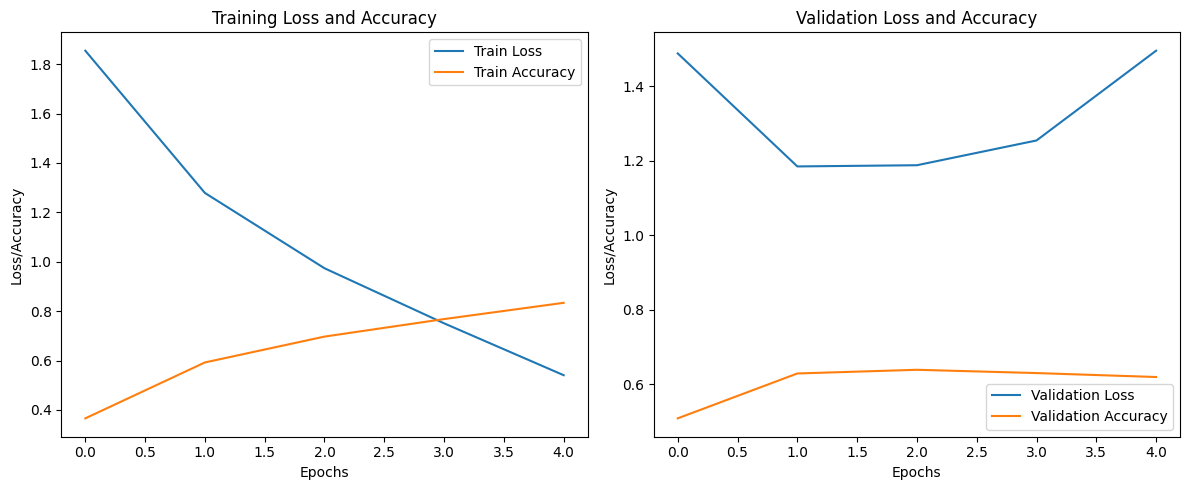

In [52]:
# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

# Plotting the validation loss and accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [55]:
# Use on the Testset and get classification report

# Predict probabilities
probabilities = model.predict(X_test)

# Convert probabilities to class labels
predictions = np.argmax(probabilities, axis=1)

# Convert one-hot encoded y_test to class labels if it's one-hot encoded
true_labels = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=label_encoder.classes_,zero_division=0)

print(report)


427/427 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

        bias       0.44      0.57      0.50      1722
   clickbait       0.40      0.27      0.32       454
  conspiracy       0.57      0.46      0.51      1262
        fake       0.88      0.80      0.84      1663
        hate       0.19      0.14      0.16       151
     junksci       0.66      0.60      0.63       215
   political       0.49      0.56      0.52      2583
    reliable       0.78      0.77      0.78      3664
       rumor       0.79      0.69      0.74       924
      satire       0.17      0.12      0.14       185
     unknown       0.41      0.41      0.41       597
  unreliable       0.67      0.36      0.47       230

    accuracy                           0.62     13650
   macro avg       0.54      0.48      0.50     13650
weighted avg       0.63      0.62      0.62     13650



In [11]:
# determine the number of cores
print(os.cpu_count())


8


[I 2024-01-02 11:04:09,753] A new study created in memory with name: no-name-8067689c-9ea3-48d4-8c5e-a82557db6a8a
[I 2024-01-02 11:04:54,493] Trial 0 finished with value: 0.10000000149011612 and parameters: {'embedding_dim': 50, 'lstm_units': 64, 'dropout_rate': 0.48178898180298335, 'batch_size': 64, 'epochs': 8}. Best is trial 0 with value: 0.10000000149011612.
[I 2024-01-02 11:05:39,953] Trial 1 finished with value: 0.10000000149011612 and parameters: {'embedding_dim': 100, 'lstm_units': 64, 'dropout_rate': 0.335115184342886, 'batch_size': 64, 'epochs': 12}. Best is trial 0 with value: 0.10000000149011612.
[I 2024-01-02 11:06:38,807] Trial 2 finished with value: 0.10000000149011612 and parameters: {'embedding_dim': 100, 'lstm_units': 64, 'dropout_rate': 0.4649114192316913, 'batch_size': 16, 'epochs': 8}. Best is trial 0 with value: 0.10000000149011612.
[I 2024-01-02 11:07:22,966] Trial 3 finished with value: 0.10000000149011612 and parameters: {'embedding_dim': 200, 'lstm_units': 32,

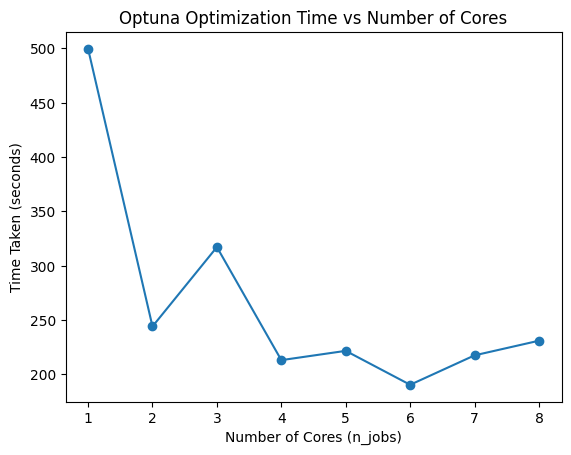

In [5]:

# show effect of parallelization on smaller dataset

# Assuming df_news is your DataFrame with 'content' and 'type' columns
X = df_news_100['content']
y = df_news_100['type']

# Tokenize and pad text
vocab_size = 10000  # Adjust as needed
max_length = 473    # Adjust based on text length
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Convert labels to categorical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)

# Define the model creation function
def create_model(trial):
    embedding_dim = trial.suggest_categorical('embedding_dim', [50, 100, 200])
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the objective function
def objective(trial):
    model = create_model(trial)

    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 5, 15)

    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=0)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

# Function to run optimization with different n_jobs
def run_optimization(n_jobs):
    start_time = time.time()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=8, n_jobs=n_jobs)  # Adjust n_trials as needed

    end_time = time.time()
    return end_time - start_time

# Running optimization for different numbers of cores
cores = range(1,9)  # From 1 to 8 cores
times = [run_optimization(n) for n in cores]

# Plotting the results
plt.plot(cores, times, marker='o')
plt.xlabel('Number of Cores (n_jobs)')
plt.ylabel('Time Taken (seconds)')
plt.title('Optuna Optimization Time vs Number of Cores')
plt.show()


In [56]:
#

**further tests from here on**

In [22]:
# Actual Model


%%time
# Parameters
vocab_size = 10000 # This can be adjusted
max_length = 60 # Adjust based on text length
embedding_dim = 1000
batch_size = 32
epochs = 5

# Preparing the Dataset
X = df_news['content']
y = df_news['type']

# Convert labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Tokenize text
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(12, activation='softmax'))


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

Epoch 1/5
1707/1707 [==============================] - 53s 27ms/step - loss: 1.8777 - accuracy: 0.3496 - val_loss: 1.7506 - val_accuracy: 0.3915
Epoch 2/5
1707/1707 [==============================] - 30s 18ms/step - loss: 1.5146 - accuracy: 0.4877 - val_loss: 1.3568 - val_accuracy: 0.5621
Epoch 3/5
1707/1707 [==============================] - 29s 17ms/step - loss: 1.2106 - accuracy: 0.6176 - val_loss: 1.2494 - val_accuracy: 0.6040
Epoch 4/5
1707/1707 [==============================] - 28s 16ms/step - loss: 1.0718 - accuracy: 0.6633 - val_loss: 1.2374 - val_accuracy: 0.6192
Epoch 5/5
427/427 [==============================] - 3s 6ms/step - loss: 1.2669 - accuracy: 0.6190
Accuracy: 0.6189743876457214
CPU times: user 3min 40s, sys: 16.1 s, total: 3min 56s
Wall time: 2min 55s


In [38]:



# Parameters
vocab_size = 10000 # This can be adjusted
max_length = 60 # Adjust based on text length
embedding_dim = 100
batch_size = 128
epochs = 15

# Preparing the Dataset
X = df_news['content']
y = df_news['type']

# Convert labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Tokenize text
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weight_dict = dict(enumerate(class_weights))

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(12, activation='softmax'))


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)


# Train the model with class weights and early stopping
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    class_weight=class_weight_dict  # Apply class weights here
)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

Epoch 1/15
427/427 [==============================] - 35s 74ms/step - loss: 2.2586 - accuracy: 0.2024 - val_loss: 2.0511 - val_accuracy: 0.3013
Epoch 2/15
427/427 [==============================] - 10s 23ms/step - loss: 2.0108 - accuracy: 0.3176 - val_loss: 2.0178 - val_accuracy: 0.2875
Epoch 3/15
427/427 [==============================] - 8s 19ms/step - loss: 2.0897 - accuracy: 0.2682 - val_loss: 2.0868 - val_accuracy: 0.2630
Epoch 4/15
427/427 [==============================] - 6s 15ms/step - loss: 1.9293 - accuracy: 0.3204 - val_loss: 1.8702 - val_accuracy: 0.3536
Epoch 5/15
427/427 [==============================] - 5s 12ms/step - loss: 1.7029 - accuracy: 0.3743 - val_loss: 1.8502 - val_accuracy: 0.3358
Epoch 6/15
427/427 [==============================] - 6s 13ms/step - loss: 1.5415 - accuracy: 0.3848 - val_loss: 1.8678 - val_accuracy: 0.3656
Epoch 7/15
427/427 [==============================] - 6s 14ms/step - loss: 1.4209 - accuracy: 0.4154 - val_loss: 1.7926 - val_accuracy: 0.34

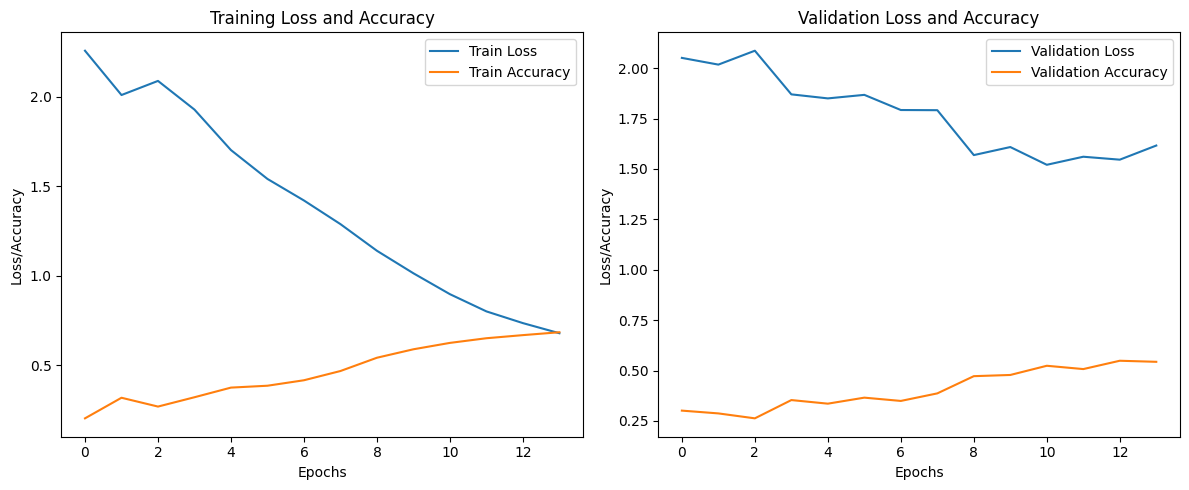

In [39]:
import matplotlib.pyplot as plt

# ... [rest of your code for training the model] ...

# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

# Plotting the validation loss and accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [40]:
# Use on the Testset and get classification report

# Predict probabilities
probabilities = model.predict(X_test)

# Convert probabilities to class labels
predictions = np.argmax(probabilities, axis=1)

# Convert one-hot encoded y_test to class labels if it's one-hot encoded
true_labels = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)
print(report)


427/427 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

        bias       0.49      0.41      0.45      1722
   clickbait       0.12      0.46      0.20       454
  conspiracy       0.49      0.38      0.43      1262
        fake       0.85      0.75      0.79      1663
        hate       0.16      0.23      0.19       151
     junksci       0.53      0.58      0.55       215
   political       0.44      0.32      0.37      2583
    reliable       0.80      0.67      0.73      3664
       rumor       0.65      0.73      0.69       924
      satire       0.06      0.18      0.09       185
     unknown       0.32      0.45      0.37       597
  unreliable       0.39      0.39      0.39       230

    accuracy                           0.52     13650
   macro avg       0.44      0.46      0.44     13650
weighted avg       0.59      0.52      0.55     13650

